# Analysis from Brian Goggin (uses newly-produced data as of September 2017)

In [2]:
import pandas as pd
import logging
import dateutil
from dateutil import parser
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
from geopandas import GeoDataFrame
from shapely.geometry import Point
%matplotlib inline
pd.set_option('display.max_columns', 500)

In [3]:
#import dataset of project times from "data" folder
file = "../data/cleaned/all_quarters__one_record_per_project.csv"
df = pd.read_csv(file)

In [4]:
#First, filter out those projects that are exclusively non-residential (defined as those without units)
df = df[df['units'] > 0]

In [5]:
#Next, keep only those that reached completion at some point over the time period
df=df[pd.notnull(df['comp_date'])]

In [6]:
df.shape

(792, 26)

In [7]:
df=df[pd.notnull(df['firstfiled'])]
df=df[df['firstfiled'] !='']

In [8]:
df.shape

(786, 26)

In [9]:
#drop duplicates for now, until manual cleaning is done
df= df[~ df.duplicated('dbi_permit', keep=False)]

In [10]:
df.shape

(713, 26)

In [11]:
#convert completion date to date variables type
df['project_duration_days'].describe()

count     713.000000
mean     1648.650771
std      1118.701060
min       157.000000
25%       769.000000
50%      1390.000000
75%      2308.000000
max      8807.000000
Name: project_duration_days, dtype: float64

In [12]:
df['project_time_years']=df['project_duration_days']/365

In [13]:
df['project_time_years'].describe()

count    713.000000
mean       4.516851
std        3.064934
min        0.430137
25%        2.106849
50%        3.808219
75%        6.323288
max       24.128767
Name: project_time_years, dtype: float64

# Zoning Exploration

In [14]:
df[df['zoning'].str.find("NCD")>=0]

,Unnamed: 0,BP_date,address,apn,best_date,best_stat,comp_date,con_date,dbi_permit,first_date,first_project_record_date,firstfiled,latest_project_record_date,latest_project_status,project_dates,project_duration_days,project_statuses,report_quarter,report_year,status,units,unitsnet,x,y,zoning,zoning_simplified,project_time_years
37,5516,2010-05-06,132 CLEMENT ST,1431022,2011-01-06,CONSTRUCTION,04/01/2011,2010-09-17,200912283901,2009-09-22,2009-09-22,2009-09-22,2011-01-06,CONSTRUCTION,"('2009-09-22', '2009-12-28', '2009-12-28', '20...",556.0,"('PL FILED', 'BP FILED', 'BP FILED', 'BP ISSUE...",1,2011,Under Construction,2.0,2.0,-122.460545,37.783256,NCD,NCD,1.523288
99,539,NaN,1315 07TH AV,1762004,2009-09-15,CONSTRUCTION,10/01/2009,2009-09-15,200606144023,2004-12-21,2009-09-15,2004-12-21,2009-09-15,CONSTRUCTION,"('2009-09-15',)",1745.0,"('CONSTRUCTION',)",3,2009,Under Construction,9.0,9.0,-122.464303,37.763718,NCD,NCD,4.780822
144,24166,2015-09-18,1656 POST ST,0686040,2016-06-06,CONSTRUCTION,07/01/2016,2016-03-22,201409237117.0,2014-09-23,2014-09-23,2014-09-23,2016-06-06,CONSTRUCTION,"('2014-09-23', '2014-09-23', '2014-09-23', '20...",647.0,"('BP FILED', 'BP FILED', 'BP FILED', 'BP FILED...",2,2016,Under Construction,4.0,4.0,-122.429080,37.785904,NCD,NCD,1.772603
239,25849,NaN,3378 SACRAMENTO ST,1008047,2016-09-08,CONSTRUCTION,10/01/2016,2016-09-08,201602099198,2016-01-22,2016-02-09,2016-01-22,2016-09-08,CONSTRUCTION,"('2016-02-09', '2016-02-09', '2016-09-08')",253.0,"('BP FILED', 'BP FILED', 'CONSTRUCTION')",3,2016,Under Construction,4.0,0.0,-122.448412,37.788135,NCD,NCD,0.693151
832,20423,2014-02-12,3820 24TH STREET,3651017,2015-06-02,CONSTRUCTION,10/01/2015,2014-05-23,201207265893.0,2012-07-19,2012-07-26,2012-07-19,2015-06-02,CONSTRUCTION,"('2012-07-26', '2012-07-26', '2012-07-26', '20...",1169.0,"('BP FILED', 'BP FILED', 'BP FILED', 'BP FILED...",3,2015,Under Construction,4.0,4.0,-122.427988,37.751907,NCD,NCD,3.202740
966,4778,NaN,590 CASTRO ST,2695016,2011-01-18,CONSTRUCTION,01/01/2011,2009-09-22,200603156751,2006-03-15,2009-09-22,2006-03-15,2011-01-18,CONSTRUCTION,"('2009-09-22', '2009-09-22', '2010-04-06', '20...",1753.0,"('CONSTRUCTION', 'CONSTRUCTION', 'CONSTRUCTION...",4,2010,Under Construction,4.0,2.0,-122.435048,37.759507,NCD,NCD,4.802740
1005,26970,2011-09-26,2034 CLEMENT ST,1412019,2014-04-10,CONSTRUCTION,01/01/2017,2012-07-12,201010253666,2010-03-16,2010-03-16,2010-03-16,2014-04-10,CONSTRUCTION,"('2010-03-16', '2010-05-26', '2010-05-26', '20...",2483.0,"('BP FILED', 'BP REINSTATED', 'BP REINSTATED',...",4,2016,Under Construction,3.0,3.0,-122.481284,37.782524,NCD,NCD,6.802740
1878,21899,2014-08-20,778 VALLEJO ST,0130020,2015-10-22,CONSTRUCTION,01/01/2016,2015-03-27,201311051179.0,2013-11-05,2013-11-05,2013-11-05,2015-10-22,CONSTRUCTION,"('2013-11-05', '2013-11-05', '2013-11-05', '20...",787.0,"('BP FILED', 'BP FILED', 'BP FILED', 'BP ISSUE...",4,2015,Under Construction,3.0,1.0,-122.410102,37.798608,NCD,NCD,2.156164
1904,22273,2015-05-21,2332 TARAVAL ST,2362019,2015-11-30,CONSTRUCTION,01/01/2016,2015-09-15,201401287236.0,2014-01-28,2014-01-28,2014-01-28,2015-11-30,CONSTRUCTION,"('2014-01-28', '2014-01-28', '2014-01-28', '20...",703.0,"('BP FILED', 'BP FILED', 'BP FILED', 'BP FILED...",4,2015,Under Construction,3.0,1.0,-122.491352,37.742609,NCD,NCD,1.926027
1999,24309,NaN,5670 MISSION ST,7099009,2016-01-22,CONSTRUCTION,07/01/2016,2015-03-27,201310250236.0,2013-10-25,2013-10-25,2013-10-25,2016-01-22,CONSTRUCTION,"('2013-10-25', '2013-10-25', '2013-10-25', '20...",980.0,"('BP FILED', 'BP FILED', 'BP FILED', 'BP FILED...",2,2016,Under Construction,2.0,2.0,-122.448632,37.710479,NCD,NCD,2.684932


In [21]:
df['zoning_simplified'].value_counts()

conv_res = ['RH-1(D)', 'RH-1', 'RH-1(S)', 'RH-2', 'RH-3']
apt_res=['RM-1', 'RM-2', 'RM-3', 'RM-4']
mixed_res=['RC-3', 'RC-4', 'RED', 'RTO', 'RC-4']
nhb_comm=['NC-1', 'NC-2', 'NC-3', 'NC-S', 'NCD', 'NCT'] #NCD and NCT encompass all types of NCD, NCTs
comm=['C-2', 'C-3', 'C-M']
indus=['M-1', 'M-2']
other=[]

def zoning_simple(value):
    zone_class='Other'
    for item in conv_res:
        if value['zoning'].find(item)>=0:
            zone_class= 'Conventional Residential'
    for item in apt_res:
        if value['zoning'].find(item)>=0: 
            zone_class= 'Apartment Residential'
    for item in mixed_res:
        if value['zoning'].find(item)>=0: 
            zone_class= 'Mixed Residential'
    for item in nhb_comm:
        if value['zoning'].find(item)>=0: 
            zone_class= 'Nhb Commercial'
    for item in comm:
        if value['zoning'].find(item)>=0: 
            zone_class= 'Standard Commercial'
    for item in indus:
        if value['zoning'].find(item)>=0: 
            zone_class= 'Industrial'
    return zone_class

df['zone_class']=df.apply(zoning_simple, axis=1)


In [22]:
df['zone_class'].value_counts()

Conventional Residential    401
Other                        80
Industrial                   72
Nhb Commercial               56
Standard Commercial          54
Mixed Residential            39
Apartment Residential        11
Name: zone_class, dtype: int64

In [30]:
#define function to make bar graphs of medians by group
def bar_graph(var_name):
    medians=[]
    for i in df[var_name].value_counts(sort=False).index:
        median = df[df[var_name]==i]['project_time_years'].median()
        medians.append(median)
        
    y_pos = np.arange(len(df[var_name].value_counts(sort=False).index))
    categories=[]
    for cat in df[var_name].value_counts(sort=False).index:
        categories.append(cat)
    plt.figure(1, figsize=(8,6), )
    plt.suptitle('Development Times by Group', fontsize=20)
    plt.ylabel('Median Development Time (Years)', fontsize=20)
    plt.xlabel(var_name, fontsize=20)
    plt.bar(y_pos, zone_medians, align='center', alpha=0.5)
    plt.xticks(y_pos, categories, fontsize=14,rotation=70)
    plt.yticks(fontsize = 14)
    plt.show()


In [32]:
y_pos

array([0, 1, 2, 3, 4, 5, 6])

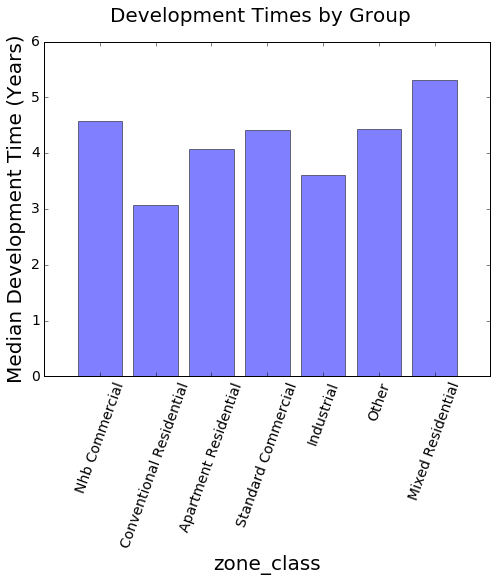

In [31]:
bar_graph('zone_class')

In [ ]:

zone_medians=[]
for i in df['zone_class'].value_counts(sort=False).index:
    median = df[df['zone_class']==i]['project_time_years'].median()
    zone_medians.append(median)
y_pos = np.arange(len(df['zone_class'].value_counts(sort=False).index))
categories=[]
for cat in df['zone_class'].value_counts(sort=False).index:
    categories.append(cat)
    
plt.figure(1, figsize=(8,6), )
plt.suptitle('Figure X. Development Time by Zoning Class', fontsize=20)
plt.ylabel('Median Development Time (Years)', fontsize=20)
plt.xlabel('Zoning Class', fontsize=20)
plt.bar(y_pos, zone_medians, align='center', alpha=0.5)
plt.xticks(y_pos, categories, fontsize=14,rotation='vertical')
plt.yticks(fontsize = 14)
#plt.savefig('../bar_chart_yearstarts.png')
plt.show()

# Project Times by Years

In [37]:
df['year_start']=df['first_date'].str[0:4].astype(int)

In [38]:
year_medians=[]
for i in df['year_start'].value_counts(sort=False).index:
    median = df[df['year_start']==i]['project_time_years'].median()
    year_medians.append(median)

In [39]:
y_pos = np.arange(len(df['year_start'].value_counts(sort=False).index))

In [40]:
categories=[]
for cat in df['year_start'].value_counts(sort=False).index:
    categories.append(cat)

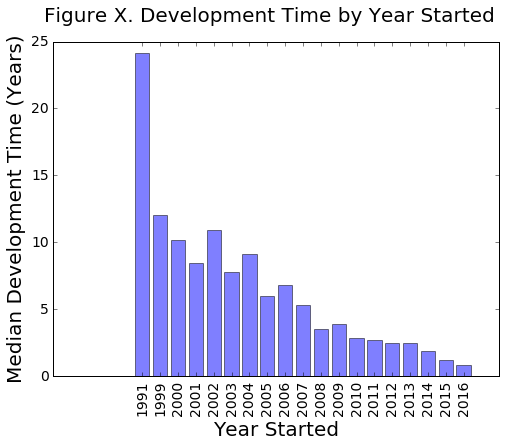

In [41]:
plt.figure(1, figsize=(8,6), )
plt.suptitle('Figure X. Development Time by Year Started', fontsize=20)
plt.ylabel('Median Development Time (Years)', fontsize=20)
plt.xlabel('Year Started', fontsize=20)
plt.bar(y_pos, year_medians, align='center', alpha=0.5)
plt.xticks(y_pos, categories, fontsize=14,rotation='vertical')
plt.yticks(fontsize = 14)
plt.savefig('../bar_chart_yearstarts.png')
plt.show()

# Figure 1. Histogram

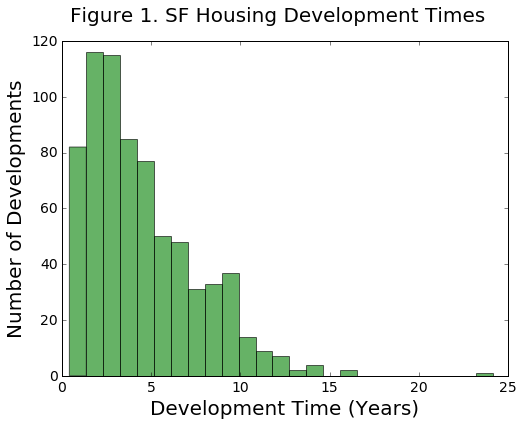

In [42]:
plt.figure(1, figsize=(8,6), )
plt.suptitle('Figure 1. SF Housing Development Times', fontsize=20)
plt.xlabel('Development Time (Years)', fontsize = 20)
plt.ylabel('Number of Developments', fontsize = 20)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
ax = plt.hist(df['project_time_years'], bins=25, alpha=.6, color='g')
plt.savefig('../hitogram.png')
plt.show()

# Isolate Big projects

In [43]:
df_big=df[df['units']>=10]

In [44]:
df_big['project_time_years'].describe()

count    162.000000
mean       5.789176
std        3.494467
min        0.534247
25%        3.130822
50%        5.015068
75%        7.663014
max       24.128767
Name: project_time_years, dtype: float64

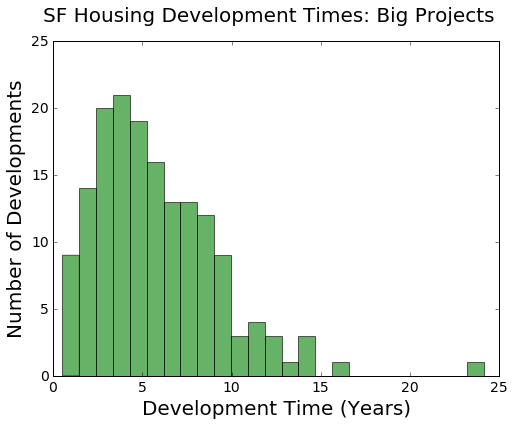

In [45]:
plt.figure(1, figsize=(8,6), )
plt.suptitle('SF Housing Development Times: Big Projects', fontsize=20)
plt.xlabel('Development Time (Years)', fontsize = 20)
plt.ylabel('Number of Developments', fontsize = 20)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
ax = plt.hist(df_big['project_time_years'], bins=25, alpha=.6, color='g')
#plt.savefig('../hitogram.png')
plt.show()

# Figure 2. Years Per Unit Histogram

In [46]:
# Project review time, normalized by amount of units
#create unit-year category so that we normalize by units when comparing geographies
df['years_per_unit']=df['project_time_years']/df['units']

In [47]:
df['years_per_unit'].describe()

count    713.000000
mean       1.907503
std        2.273052
min        0.001935
25%        0.431507
50%        1.107763
75%        2.447489
max       13.243836
Name: years_per_unit, dtype: float64

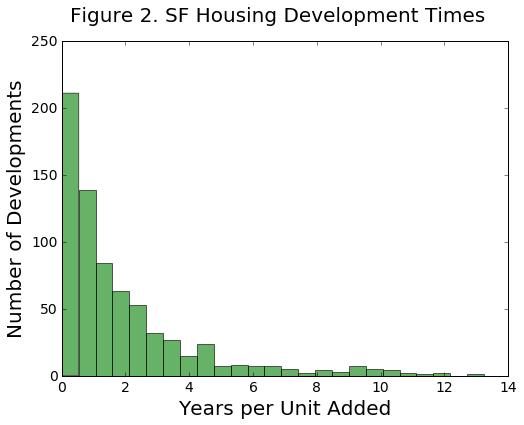

In [48]:
plt.figure(1, figsize=(8,6), )
plt.suptitle('Figure 2. SF Housing Development Times', fontsize=20)
plt.xlabel('Years per Unit Added', fontsize=20)
plt.ylabel('Number of Developments', fontsize=20)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
ax = plt.hist(df['years_per_unit'], bins=25, alpha=.6, color='g')
plt.savefig('../hitogram_yearunits.png')
plt.show()

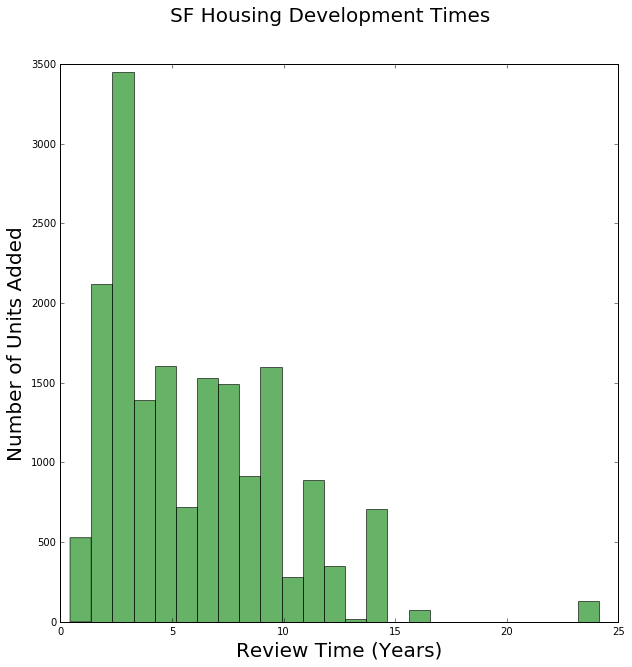

In [49]:
#Create dataset units added by years for each unit
list = []
uniqueid = 0
for index, row in df.iterrows():
    amount = int(row['units'])
    for units in range(0, amount):
        dictionary = {}
        dictionary['id']=uniqueid+1
        dictionary['time']=row['project_time_years']
        list.append(dictionary)
        uniqueid=uniqueid+1
df_units = pd.DataFrame(list)

plt.figure(1, figsize=(10,10), )
plt.suptitle('SF Housing Development Times', fontsize=20)
plt.xlabel('Review Time (Years)', fontsize = 20)
plt.ylabel('Number of Units Added', fontsize = 20)
ax = plt.hist(df_units['time'], bins=25, alpha=.6, color='g')
plt.savefig('../hitogram_units.png')
plt.show()

In [50]:
df_units['time'].describe()

count    17799.000000
mean         5.977264
std          3.945288
min          0.430137
25%          2.758904
50%          5.000000
75%          8.654795
max         24.128767
Name: time, dtype: float64

# Figure 4. Scatter Plots

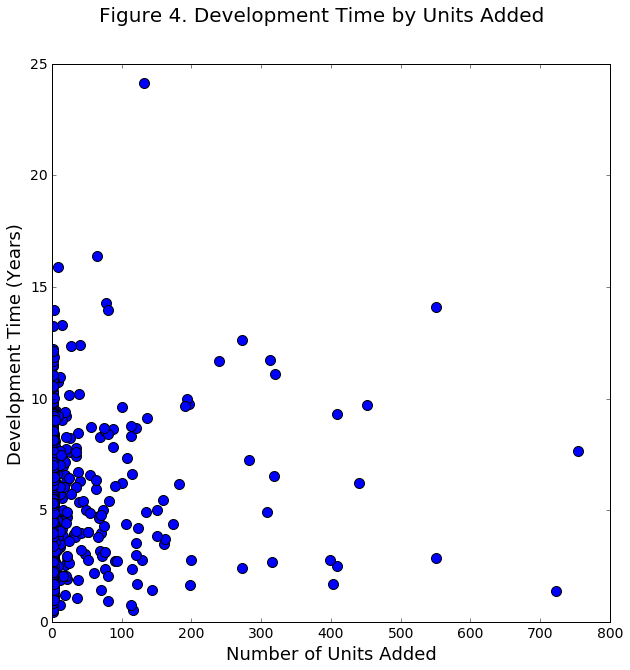

In [51]:
plt.figure(1, figsize=(10,10))
plt.scatter(df['units'], df['project_time_years'], s=100)
plt.suptitle('Figure 4. Development Time by Units Added', fontsize=20)
plt.ylabel('Development Time (Years)', fontsize = 18)
plt.xlabel('Number of Units Added', fontsize = 18)
plt.xticks(fontsize=14)
plt.yticks(fontsize = 14)
plt.xlim([0,800])
plt.ylim([0,25])
plt.savefig('../scatter.png')

(0, 25)

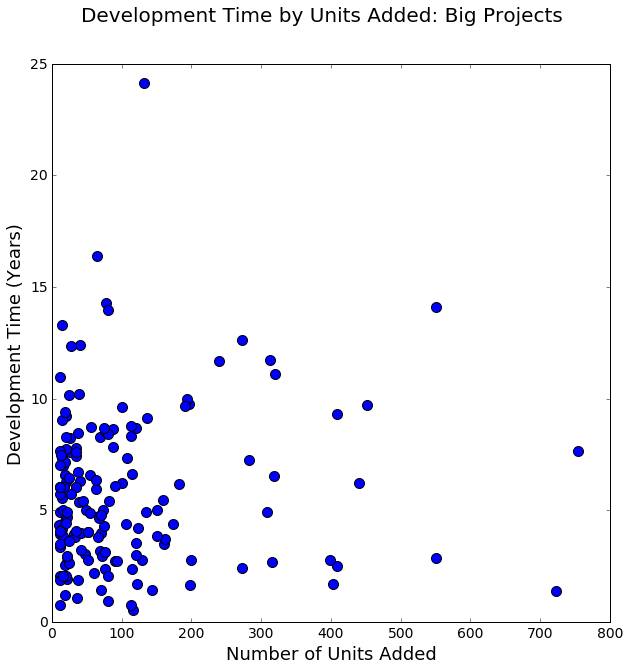

In [52]:
plt.figure(1, figsize=(10,10))
plt.scatter(df_big['units'], df_big['project_time_years'], s=100)
plt.suptitle('Development Time by Units Added: Big Projects', fontsize=20)
plt.ylabel('Development Time (Years)', fontsize = 18)
plt.xlabel('Number of Units Added', fontsize = 18)
plt.xticks(fontsize=14)
plt.yticks(fontsize = 14)
plt.xlim([0,800])
plt.ylim([0,25])
#plt.savefig('../scatter.png')

# Figure 5. Plot by unit category

In [31]:
unit_cutoffs=[10, 50, 100, 200]
def unit_categories(value):
    if value['units'] <unit_cutoffs[0]:
        field = '0'+'-'+str(unit_cutoffs[0])
    elif (value['units'] >=unit_cutoffs[0]) & (value['units'] <unit_cutoffs[1]):
        field = str(unit_cutoffs[0])+'-'+str(unit_cutoffs[1])
    elif (value['units']>= unit_cutoffs[1]) & (value['units'] <unit_cutoffs[2]):
        field = str(unit_cutoffs[1])+'-'+str(unit_cutoffs[2])
    elif (value['units']>= unit_cutoffs[2]) & (value['units'] <200):
        field = str(unit_cutoffs[2])+'-'+str(unit_cutoffs[3])
    elif value['units']>=200:
        field = '>'+str(unit_cutoffs[3])
    return field
    
df['unitcat']=df.apply(unit_categories, axis=1)

In [32]:
df['unitcat'].value_counts()

0-10       551
10-50       75
50-100      36
100-200     31
>200        20
Name: unitcat, dtype: int64

In [33]:
cat_medians=[]
categories=['0-10', '10-50', '50-100', '100-200', '>200']
for cat in categories:
    median = df[df['unitcat']==cat]['project_time_years'].median()
    cat_medians.append(median)
objects = df['unitcat'].unique()
y_pos = np.arange(len(objects))

In [34]:
df['unitcat'].unique()

array(['0-10', '10-50', '50-100', '100-200', '>200'], dtype=object)

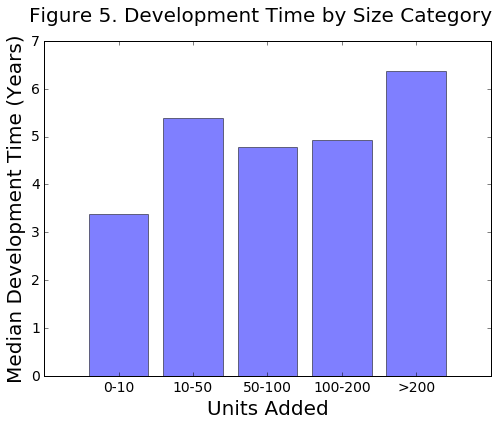

In [35]:
plt.figure(1, figsize=(8,6), )
plt.suptitle('Figure 5. Development Time by Size Category', fontsize=20)
plt.ylabel('Median Development Time (Years)', fontsize=20)
plt.xlabel('Units Added', fontsize=20)
plt.bar(y_pos, cat_medians, align='center', alpha=0.5)
plt.xticks(y_pos, categories, fontsize=14)
plt.yticks(fontsize = 14)
plt.savefig('../bar_chart_times.png')
plt.show()

# Top 5 Longest and Shortest

In [37]:
# Top 5 longest projects
df.sort_values('project_time_years', ascending = False)[0:5]

,Unnamed: 0,BP_date,address,apn,best_date,best_stat,comp_date,con_date,dbi_permit,first_date,first_project_record_date,firstfiled,latest_project_record_date,latest_project_status,project_dates,project_duration_days,project_statuses,report_quarter,report_year,status,units,unitsnet,x,y,project_time_years,years_per_unit,unitcat
2349,18560,NaN,833-881 JAMESTOWN,4991277,2007-09-17,CONSTRUCTION,04/01/2015,2007-09-17,9924080S,1991-02-19,2007-09-17,1991-02-19,2007-09-17,CONSTRUCTION,"('2007-09-17', '2007-09-17', '2007-09-17', '20...",8807.0,"('CONSTRUCTION', 'CONSTRUCTION', 'CONSTRUCTION...",1,2015,Under Construction,132.0,14.0,-122.392222,37.717174,24.128767,0.182794,100-200
624,26437,NaN,POTRERO1010 (BLDG 1 OF 2),3833001,2016-05-26,CONSTRUCTION,10/01/2016,2016-05-26,201112070227,2000-05-18,2016-05-26,2000-05-18,2016-05-26,CONSTRUCTION,"('2016-05-26', '2016-05-26')",5980.0,"('CONSTRUCTION', 'CONSTRUCTION')",3,2016,Under Construction,65.0,65.0,-122.396595,37.767108,16.383562,0.252055,50-100
3206,17247,2008-11-07,1179 TENNESSEE ST,4172053,2014-12-18,CONSTRUCTION,01/01/2015,2014-03-21,9902819.0,1999-02-11,2008-11-07,1999-02-11,2014-12-18,CONSTRUCTION,"('2008-11-07', '2009-11-03', '2009-11-03', '20...",5803.0,"('BP REINSTATED', 'BP REINSTATED', 'BP REINSTA...",4,2014,Under Construction,8.0,8.0,-122.389058,37.755993,15.898630,1.987329,0-10
225,24780,2014-02-12,480 POTRERO AV,3973002C,2016-01-13,CONSTRUCTION,07/01/2016,2015-03-26,201306250465,2002-03-22,2004-08-17,2002-03-22,2016-01-13,CONSTRUCTION,"('2004-08-17', '2012-10-04', '2012-10-04', '20...",5215.0,"('BP ISSUED', 'PL FILED', 'PL FILED', 'BP FILE...",2,2016,Under Construction,77.0,77.0,-122.407671,37.763478,14.287671,0.185554,50-100
621,27882,2013-10-31,TRINITY PLAZA PHASE III,3702391,2016-11-09,CONSTRUCTION,01/01/2017,2015-10-14,201209069080,2002-11-21,2013-10-31,2002-11-21,2016-11-09,CONSTRUCTION,"('2013-10-31', '2015-10-14', '2015-12-21', '20...",5155.0,"('BP ISSUED', 'CONSTRUCTION', 'CONSTRUCTION', ...",4,2016,Under Construction,550.0,550.0,-122.413013,37.777926,14.123288,0.025679,>200


In [38]:
# Top 5 longest projects
df.sort_values('project_time_years', ascending = True)[0:5]

,Unnamed: 0,BP_date,address,apn,best_date,best_stat,comp_date,con_date,dbi_permit,first_date,first_project_record_date,firstfiled,latest_project_record_date,latest_project_status,project_dates,project_duration_days,project_statuses,report_quarter,report_year,status,units,unitsnet,x,y,project_time_years,years_per_unit,unitcat
745,2346,NaN,850 30TH AV,1672024,2010-02-24,CONSTRUCTION,04/01/2010,2010-02-24,200910269851,2009-10-26,2009-10-26,2009-10-26,2010-02-24,CONSTRUCTION,"('2009-10-26', '2010-02-24')",157.0,"('BP FILED', 'CONSTRUCTION')",1,2010,Under Construction,2.0,NaN,-122.489282,37.773244,0.430137,0.215068,0-10
17,21046,NaN,414 SOMERSET ST,6044003,2015-10-05,CONSTRUCTION,2015-10-05,2015-10-05,201504103396.0,2015-04-10,2015-04-10,2015-04-10,2015-10-05,CONSTRUCTION,"('2015-04-10', '2015-10-05')",178.0,"('BP FILED', 'CONSTRUCTION')",3,2015,Under Construction,2.0,1.0,-122.407649,37.726252,0.487671,0.243836,0-10
147,10897,2012-10-26,55 05TH ST,3705039,2012-12-12,CONSTRUCTION,01/01/2013,2012-12-12,201206202986,2012-06-20,2012-06-20,2012-06-20 00:00:00,2012-12-12,CONSTRUCTION,"('2012-06-20', '2012-10-26', '2012-12-12')",195.0,"('BP FILED', 'BP APPROVED', 'CONSTRUCTION')",4,2012,Under Construction,116.0,8.0,-122.407185,37.783461,0.534247,0.004606,100-200
2322,10900,2012-10-23,28 PRECITA AV,5518023,2012-11-15,CONSTRUCTION,01/01/2013,2012-11-15,201206203050,2012-06-20,2012-06-20,2012-06-20 00:00:00,2012-11-15,CONSTRUCTION,"('2012-06-20', '2012-10-23', '2012-11-15')",195.0,"('BP FILED', 'BP ISSUED', 'CONSTRUCTION')",4,2012,Under Construction,2.0,1.0,-122.418489,37.746472,0.534247,0.267123,0-10
3348,656,NaN,64 14TH ST,3529017,2009-08-07,CONSTRUCTION,10/01/2009,2009-08-07,200903194471,2009-03-19,2009-08-07,2009-03-19,2009-08-07,CONSTRUCTION,"('2009-08-07',)",196.0,"('CONSTRUCTION',)",3,2009,Under Construction,1.0,-1.0,-122.414942,37.768706,0.536986,0.536986,0-10


# Figures 3 and 6. Breakdown time by stage of process

In [45]:
df = df[pd.notnull(df['BP_date'])]

In [46]:
df.shape

(471, 28)

In [47]:
df = df[pd.notnull(df['con_date'])]

In [48]:
df.shape

(471, 28)

In [49]:
df['permit_time']=df.apply(lambda x: ((dateutil.parser.parse(x['BP_date']) - dateutil.parser.parse(x['first_date'])).days)/365, axis=1)
df['bp_time']=df.apply(lambda x: ((dateutil.parser.parse(x['con_date']) - dateutil.parser.parse(x['BP_date'])).days)/365, axis=1)
df['con_time']=df.apply(lambda x: ((dateutil.parser.parse(x['comp_date']) - dateutil.parser.parse(x['con_date'])).days)/365, axis=1)

In [50]:
df['bp_time'].describe()

count    471.000000
mean       1.076625
std        1.191285
min        0.054795
25%        0.397260
50%        0.663014
75%        1.236986
max        7.019178
Name: bp_time, dtype: float64

In [51]:
df['con_time'].describe()

count    471.000000
mean       1.071785
std        0.953730
min        0.000000
25%        0.452055
50%        0.846575
75%        1.384932
max        5.745205
Name: con_time, dtype: float64

In [52]:
df['project_time_years'].describe()

count    471.000000
mean       4.410622
std        2.843582
min        0.534247
25%        2.134247
50%        3.717808
75%        6.147945
max       15.898630
Name: project_time_years, dtype: float64

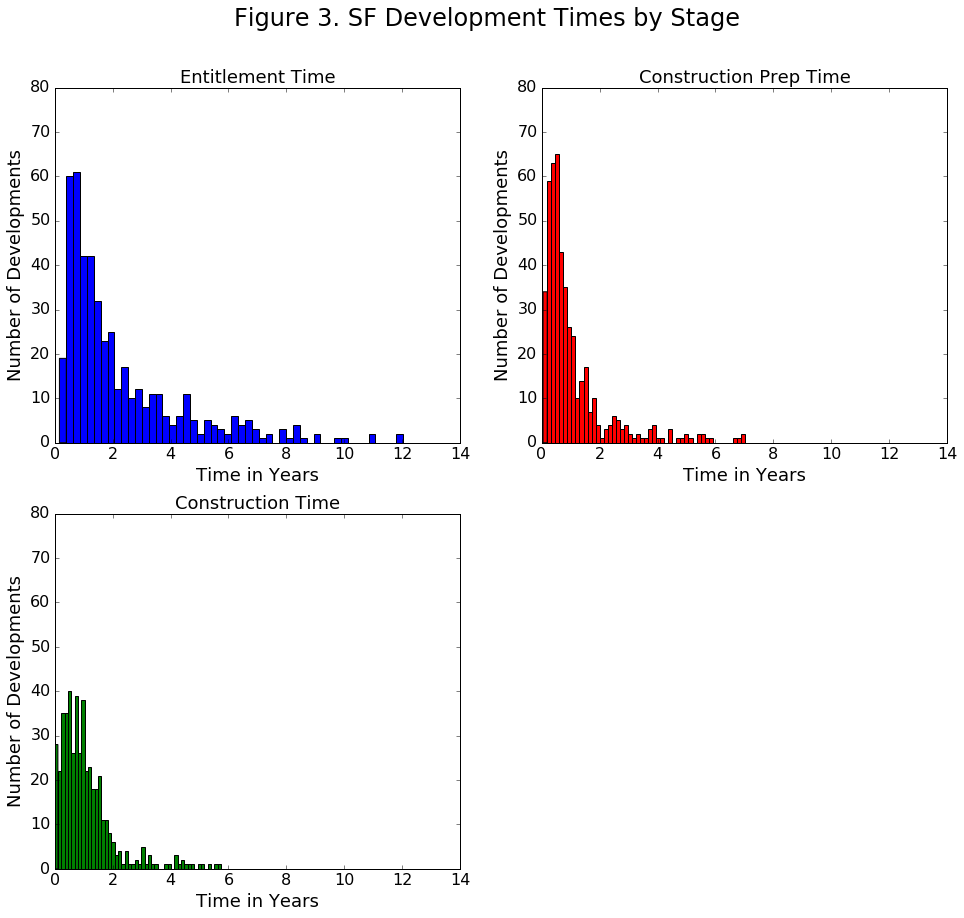

In [53]:
plt.figure(1, figsize=(16,14), )
plt.suptitle("Figure 3. SF Development Times by Stage", fontsize=24)

ax = plt.subplot(221)
ax.set_title("Entitlement Time", fontsize=18)
ax.set_xlabel('Time in Years', fontsize=18)
ax.set_ylabel('Number of Developments', fontsize=18)
plt.xlim([0,14])
plt.ylim([0,80])
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
ax.hist(df['permit_time'], bins=50, color='b')

ax = plt.subplot(222)
ax.set_title("Construction Prep Time", fontsize=18)
ax.set_xlabel('Time in Years', fontsize=18)
ax.set_ylabel('Number of Developments', fontsize=18)
plt.xlim([0,14])
plt.ylim([0,80])
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
ax.hist(df['bp_time'], bins=50, color='r')

ax = plt.subplot(223)
ax.set_title("Construction Time", fontsize=18)
ax.set_xlabel('Time in Years', fontsize=18)
ax.set_ylabel('Number of Developments', fontsize=18)
plt.xlim([0,14])
plt.ylim([0,80])
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
ax.hist(df['con_time'], bins=50, color='g')

plt.savefig('../big_hist.png')

In [54]:
ent_medians=[]
bp_medians=[]
cons_medians=[]
categories=['0-10', '10-50', '50-100', '100-200', '>200']
for cat in categories:
    median1 = df[df['unitcat']==cat]['permit_time'].median()
    median2 = df[df['unitcat']==cat]['bp_time'].median()
    median3 = df[df['unitcat']==cat]['con_time'].median()
    ent_medians.append(median1)
    bp_medians.append(median2)
    cons_medians.append(median3)
objects = df['unitcat'].unique()
y_pos = np.arange(len(objects))

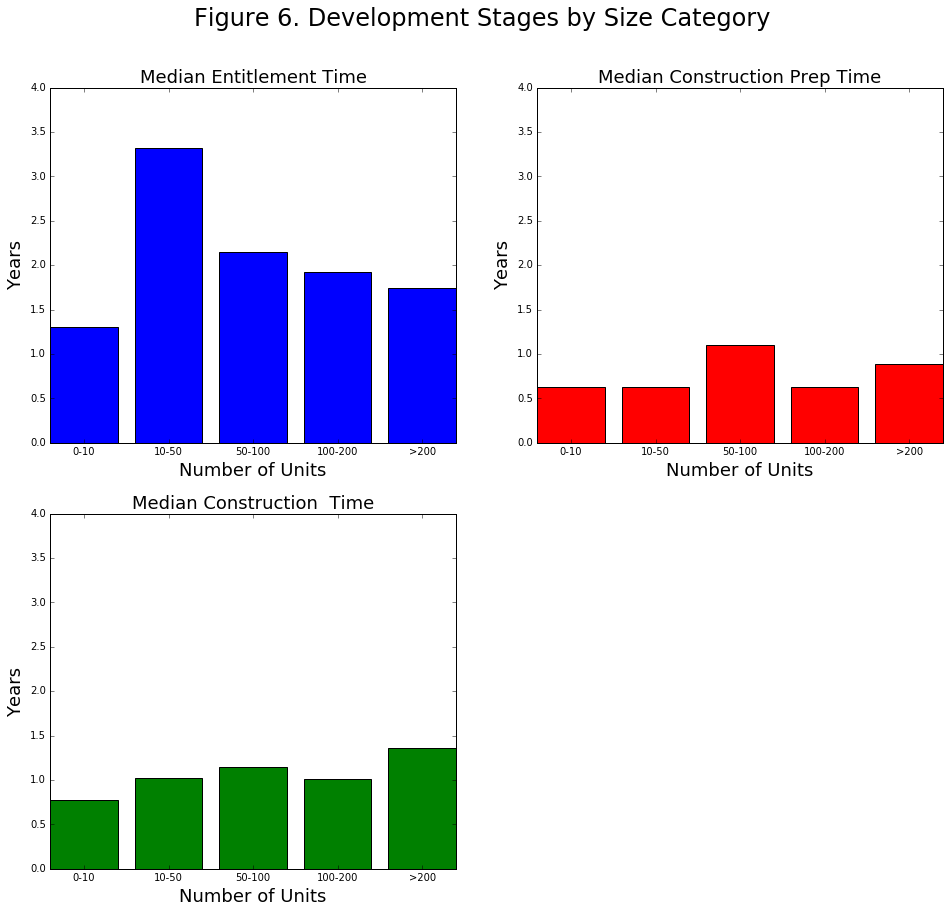

In [55]:
plt.figure(1, figsize=(16,14), )
plt.suptitle("Figure 6. Development Stages by Size Category", fontsize=24)

ax = plt.subplot(221)
ax.set_title('Median Entitlement Time', fontsize=18)
ax.set_xlabel('Number of Units', fontsize=18)
ax.set_ylabel('Years', fontsize=18)
ax.set_xticks(y_pos)
ax.set_xticklabels(categories)
ax.set_ylim([0,4])
ax.bar(y_pos, ent_medians, align='center', color='b')

ax = plt.subplot(222)
ax.set_title('Median Construction Prep Time', fontsize=18)
ax.set_xlabel('Number of Units', fontsize=18)
ax.set_ylabel('Years', fontsize=18)
ax.set_xticks(y_pos)
ax.set_xticklabels(categories)
ax.set_ylim([0,4])
ax.bar(y_pos, bp_medians, align='center', color='r')

ax = plt.subplot(223)
ax.set_title('Median Construction  Time', fontsize=18)
ax.set_xlabel('Number of Units', fontsize=18)
ax.set_ylabel('Years', fontsize=18)
ax.set_xticks(y_pos)
ax.set_xticklabels(categories)
ax.set_ylim([0,4])
ax.bar(y_pos, cons_medians, align='center', color='g')

plt.savefig('../big_bar.png')

# Figures 7 and 8. Create Neighborhood Graphs

In [56]:
#first, convert points to geodataframe
crs = {'init' :'epsg:4326'}
geometry = [Point(xy) for xy in zip(df.x, df.y)]
devs = GeoDataFrame(df, crs=crs, geometry=geometry)
devs = devs.to_crs({'init': 'epsg:4326'}) 

In [57]:
devs.shape

(471, 31)

In [58]:
#import neighborhoods
neighborhoods = gpd.read_file('../data/gis/41_neighborhoods/41_neighborhoods.shp')

In [59]:
#convert boundaries to geographic coordinate system to conform to points
neighborhoods = neighborhoods.to_crs({'init': 'epsg:4326'}) 

In [60]:
neighborhoods.shape

(41, 2)

In [61]:
#First, spatial join between points and neighborhood boundaries. Set 'how' to 'left' to preserve all developments
df_nb = gpd.sjoin(devs, neighborhoods, how = 'inner', op='within')
df_nb.shape

(471, 33)

In [62]:
#create separate geodataframe for just those with all dates
df_nb_full = df_nb[pd.notnull(df_nb['BP_date'])]

In [63]:
# for these graphs, drop if neighborhood has sample less than 10
for nhood in df_nb_full['nhood'].value_counts().index:
    if df_nb_full[df_nb_full['nhood']==nhood]['BP_date'].count() <10:
        df_nb_full=df_nb_full[df_nb_full['nhood']!=nhood]

In [64]:
df_nb_full['permit_time']=df_nb_full.apply(lambda x: ((dateutil.parser.parse(x['BP_date']) - dateutil.parser.parse(x['first_date'])).days)/365, axis=1)


In [65]:
df_nb_full['ptime_unityears']=df_nb_full['permit_time']/df_nb_full['units']

In [66]:
p_medians=[]
pcategories = df_nb_full['nhood'].unique().tolist()
pcategories = sorted(pcategories, key=lambda x: df_nb_full[df_nb_full['nhood']==x]['ptime_unityears'].median())

In [67]:
for cat in pcategories:
    median = df_nb_full[df_nb_full['nhood']==cat]['ptime_unityears'].median()
    p_medians.append(median)
y_pos=np.arange(len(pcategories))

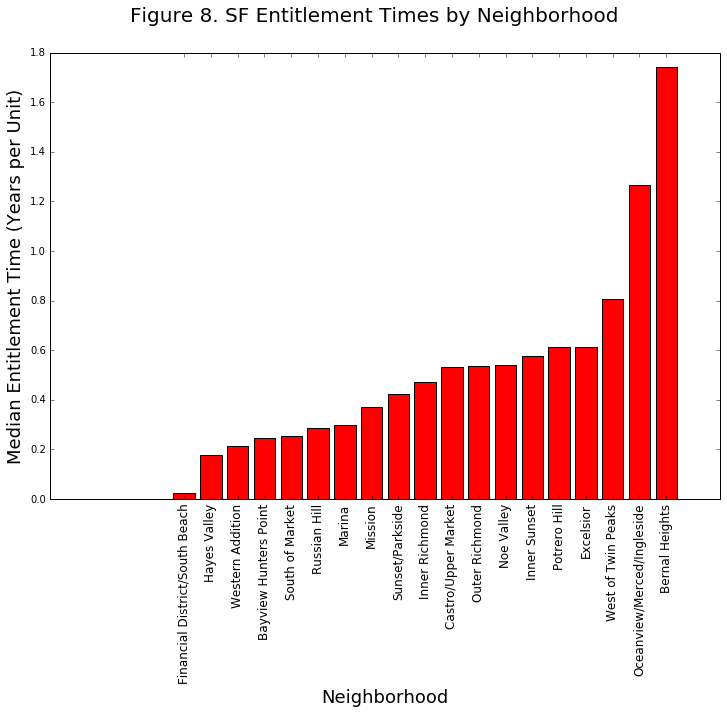

In [68]:
plt.figure(1, figsize=(12,8))
plt.suptitle('Figure 8. SF Entitlement Times by Neighborhood', fontsize=20)
plt.ylabel('Median Entitlement Time (Years per Unit)', fontsize=18)
plt.xlabel('Neighborhood', fontsize=18)
plt.bar(y_pos, p_medians, align='center', alpha=1, width=0.8, color='r')
plt.xticks(y_pos, pcategories, rotation=90, fontsize=12)
plt.savefig('../nhood2.png')
plt.show()

In [69]:
cat_medians=[]
categories=df_nb_full['nhood'].unique().tolist()
categories = sorted(categories, key=lambda x: df_nb_full[df_nb_full['nhood']==x]['years_per_unit'].median())

In [70]:
for cat in categories:
    median = df_nb_full[df_nb_full['nhood']==cat]['years_per_unit'].median()
    cat_medians.append(median)

In [71]:
y_pos=np.arange(len(categories))

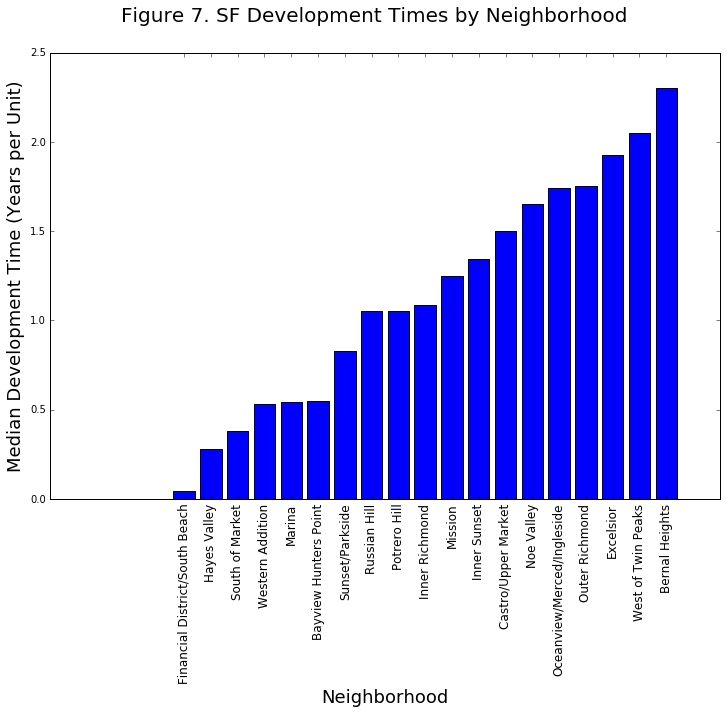

In [72]:
plt.figure(1, figsize=(12,8))
plt.suptitle('Figure 7. SF Development Times by Neighborhood', fontsize=20)
plt.ylabel('Median Development Time (Years per Unit)', fontsize=18)
plt.xlabel('Neighborhood', fontsize=18)
plt.bar(y_pos, cat_medians, align='center', alpha=1, width=0.8, color='b')
plt.xticks(y_pos, categories, rotation=90, fontsize=12)
plt.savefig('../nhood1.png')
plt.show()

In [73]:
df_nb_full.shape

(389, 34)